In [7]:
'''
Description: 
Author: Jiaqi Gu (jiaqigu@asu.edu)
Date: 2023-10-03 12:12:40
LastEditors: ScopeX-ASU jiaqigu@asu.edu
LastEditTime: 2023-10-03 12:12:57
'''
import meep as mp
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
from IPython.display import Video

# n = 3.4  # index of waveguide
n = 2.45  # index of waveguide, 1550 nm, TE0 mode, 220nm thinkness, 500 nm width
w = 0.5  # width of waveguide
r = 5  # inner radius of ring
wg_gap = 0.15
pad = 1.5  # padding between waveguide and edge of PML
dpml = 2  # thickness of PML
sxy = 2 * (r + w + pad + dpml)  # cell size
res = 15

In [8]:
c1 = mp.Cylinder(radius=r + w, material=mp.Medium(index=n))
c2 = mp.Cylinder(radius=r)
wg_ycenter = -(r + w + wg_gap + w / 2)
c3 = mp.Block(
        mp.Vector3(mp.inf, w, mp.inf),
        center=mp.Vector3(y=wg_ycenter),
        material=mp.Medium(index=n),
    )

In [9]:
fcen = 1/1.55  # pulse center frequency
# df = fcen - 0.05  # pulse frequency width
df = 1/1.5 - 1/1.6  # pulse frequency width
src = mp.EigenModeSource(
            src=mp.GaussianSource(fcen, fwidth=df),
            center=mp.Vector3(-sxy/2+dpml, wg_ycenter),
            size=(0, w, 0),
            eig_match_freq=True,
            eig_parity=mp.ODD_Z + mp.EVEN_Y,
        )



In [10]:
sim = mp.Simulation(
    cell_size=mp.Vector3(sxy+1, sxy),
    boundary_layers=[mp.PML(dpml)],
    geometry=[c3],
    sources=[src],
    resolution=res,
    output_single_precision=True,
)

nfreq = 400  # number of frequencies at which to compute flux
# transmitted flux
tran_fr = mp.FluxRegion(
    center=mp.Vector3(0.5 * sxy - dpml, wg_ycenter, 0), size=mp.Vector3(0, 2 * w, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# plt.figure(dpi=150)
# sim.plot2D()
# plt.show()

pt = mp.Vector3(0.5 * sxy - dpml - 0.5, wg_ycenter)

f = plt.figure(dpi=150)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
efield_z_list = []
def record_efield_z(sim):
    efield_z_list.append(sim.get_efield_z())
    
# sim.run(mp.at_every(0.5, Animate), until=240)
# sim.run(mp.to_appended("data_dump/wg_eps", mp.at_beginning(mp.output_epsilon)),
#         mp.to_appended("data_dump/wg_ez", mp.at_every(0.6, mp.output_efield_z)),
#         until = 240,
#         )
sim.run(mp.at_every(0.6, record_efield_z),
        until = 240,
        )
print(len(efield_z_list))
print(efield_z_list[0].shape)
plt.close()
straight_tran_flux = mp.get_fluxes(tran)

# Process the animation and view it
filename = "media/ring_simple_wg.mp4"
Animate.to_mp4(20, filename)
# Animate.to_gif(5, filename)
Video(filename)

# for normalization run, save flux fields data for reflection plane

-----------
Initializing structure...
time for choose_chunkdivision = 0.000356148 s
Working in 2D dimensions.
Computational cell is 19 x 18 x 0 with resolution 15
     block, center = (0,-5.9,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)


          dielectric constant epsilon diagonal = (6.0025,6.0025,6.0025)
time for set_epsilon = 0.102452 s
-----------


MPB solved for frequency_1(1.58065,0,0) = 0.666547 after 9 iters
MPB solved for frequency_1(1.5296,0,0) = 0.645155 after 5 iters
MPB solved for frequency_1(1.52962,0,0) = 0.645161 after 2 iters


FloatProgress(value=0.0, description='0% done ', max=240.0)

run 0 finished at t = 240.0 (7200 timesteps)
400
(285, 270)
Generating MP4...


In [5]:
fields = sim.fields
import os
os.makedirs("./data_dump", exist_ok=True)
sim.dump("./data_dump")

Dumped structure to file: ./data_dump/structure.h5 (True)
Dumped fields to file: ./data_dump/fields.h5 (True)
creating epsilon from file "./data_dump/structure.h5" (1)...
creating fields output file "./data_dump/fields.h5" (1)...


     block, center = (0,-5.9,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0025,6.0025,6.0025)
1.1298004652865385
Keys: <KeysViewHDF5 ['eps']>
eps (270, 270, 1)
1.1298004652865385


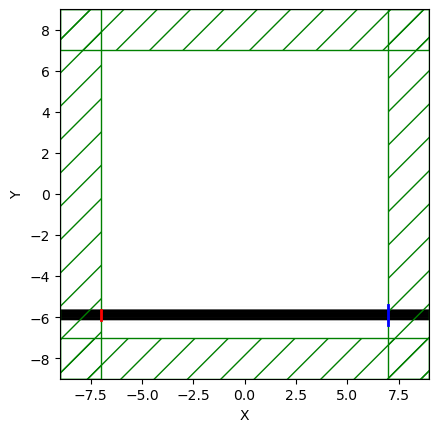

In [22]:
import h5py
dirname = "./data_dump"
structure_filename = dirname + "/wg_eps.h5"
field_filename = dirname + "/wg_ez.h5"
# mp.output_epsilon(sim)
# field_z = sim.get_efield_z()
eps = sim.get_epsilon()
sim.plot2D()
print(np.mean(eps))
# print(field_z.shape, field_z.dtype)
# print(eps.shape, eps.dtype)
# print(mp.output_epsilon(sim))


# with h5py.File("./eps-000240.00.h5", "r") as f:
with h5py.File(structure_filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    for a_group_key in f.keys():
        ds_arr = f[a_group_key][()]
        print(a_group_key, ds_arr.shape)
        # print(ds_arr / np.max(np.abs(ds_arr)))
        print(np.mean(ds_arr))


    # get the object type for a_group_key: usually group or dataset
    # print(type(f[a_group_key])) 

    # # If a_group_key is a group name, 
    # # this gets the object names in the group and returns as a list
    # data = list(f[a_group_key])

    # # If a_group_key is a dataset name, 
    # # this gets the dataset values and returns as a list
    # data = list(f[a_group_key])
    # # preferred methods to get dataset values:
    # ds_obj = f[a_group_key]      # returns as a h5py dataset object
    # ds_arr = f[a_group_key][()]  # returns as a numpy array
    # print(ds_obj)

     cylinder, center = (0,0,0)
          radius 5.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (6.0025,6.0025,6.0025)
     cylinder, center = (0,0,0)
          radius 5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-5.9,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0025,6.0025,6.0025)


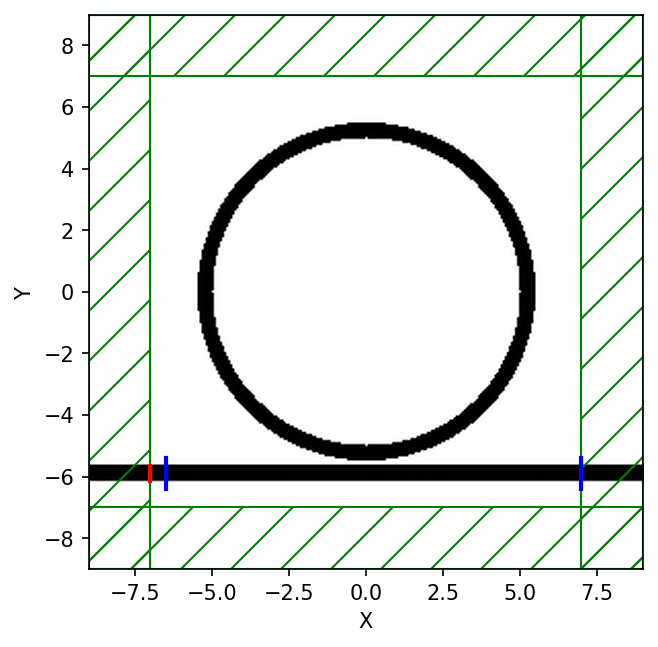

In [11]:
sim.reset_meep()
sim = mp.Simulation(
    cell_size=mp.Vector3(sxy, sxy),
    geometry=[c1, c2, c3],
    sources=[src],
    resolution=res,
    boundary_layers=[mp.PML(dpml)],
)
nfreq = 400  # number of frequencies at which to compute flux
# transmitted flux
inp_fr = mp.FluxRegion(
    center=mp.Vector3(-0.5 * sxy + dpml + 0.5, wg_ycenter, 0), size=mp.Vector3(0, 2 * w, 0)
)
tran_fr = mp.FluxRegion(
    center=mp.Vector3(0.5 * sxy - dpml, wg_ycenter, 0), size=mp.Vector3(0, 2 * w, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)
inp = sim.add_flux(fcen, df, nfreq, inp_fr)

plt.figure(dpi=150)
sim.plot2D()
plt.show()

In [12]:
pt = mp.Vector3(sxy/2-dpml, wg_ycenter)
f = plt.figure(dpi=150)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)

sim.run(
    mp.at_beginning(Animate),
    # mp.at_beginning(mp.output_epsilon),
    mp.after_sources(mp.Harminv(mp.Ez, pt, fcen, df)),
    mp.at_every(0.3, Animate), # 0.3 times unit = 0.3*20 = 6 timestep = 6 * 0.16666 fs = 1 fs
    # mp.at_every(0.6, Animate), # 0.6 times unit = 0.6*20 = 12 timestep = 12 * 0.16666 fs = 2 fs
    until=2400, # 8 ps = 8000 * 0.3 = total 2400 time unit
    # until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(r+0.2), 1e-3),
)
ring_tran_flux = mp.get_fluxes(tran)
ring_inp_flux = mp.get_fluxes(inp)

flux_freqs = mp.get_flux_freqs(tran)
# Close the animator's working frame
plt.close()

# Process the animation and view it
filename = "media/ring_simple_2000_0.3.mp4"
Animate.to_mp4(60, filename)
# Animate.to_gif(5, filename)
Video(filename)


-----------
Initializing structure...
time for choose_chunkdivision = 0.000306204 s
Working in 2D dimensions.
Computational cell is 18 x 18 x 0 with resolution 15
     cylinder, center = (0,0,0)
          radius 5.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (6.0025,6.0025,6.0025)
     cylinder, center = (0,0,0)
          radius 5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-5.9,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0025,6.0025,6.0025)
time for set_epsilon = 0.259076 s
-----------


MPB solved for frequency_1(1.58065,0,0) = 0.666547 after 9 iters
MPB solved for frequency_1(1.5296,0,0) = 0.645155 after 5 iters
MPB solved for frequency_1(1.52962,0,0) = 0.645161 after 2 iters


FloatProgress(value=0.0, description='0% done ', max=2400.0)

     cylinder, center = (0,0,0)
          radius 5.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (6.0025,6.0025,6.0025)
     cylinder, center = (0,0,0)
          radius 5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-5.9,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0025,6.0025,6.0025)
Meep progress: 191.7/2400.0 = 8.0% done in 4.0s, 46.1s to go
on time step 5797 (time=193.233), 0.000690052 s/step
Meep progress: 380.1/2400.0 = 15.8% done in 8.0s, 42.5s to go
on time step 11448 (time=381.6), 0.000708241 s/step
Meep progress: 571.5/2400.0 = 23.8% done in 12.0s, 38.4s to go
on time step 17191 (time=573.033), 0.00069652 s/step
Meep progress: 758.4/2400.0 = 31.6% done in 16.0s, 34.7s to go
on time step 22797 (time=759.9), 0.000714155 s/step
Meep progress: 946.8333333333334/2400.0 = 39.5% done in 20.0s, 30.7s t

[0.6243279569892473, 0.624432384725254, 0.6245368124612606, 0.6246412401972673, 0.624745667933274, 0.6248500956692806, 0.6249545234052873, 0.6250589511412941, 0.6251633788773008, 0.6252678066133074, 0.6253722343493141, 0.6254766620853208, 0.6255810898213274, 0.6256855175573341, 0.6257899452933409, 0.6258943730293475, 0.6259988007653542, 0.6261032285013609, 0.6262076562373675, 0.6263120839733742, 0.626416511709381, 0.6265209394453876, 0.6266253671813943, 0.626729794917401, 0.6268342226534077, 0.6269386503894143, 0.627043078125421, 0.6271475058614278, 0.6272519335974344, 0.6273563613334411, 0.6274607890694478, 0.6275652168054544, 0.6276696445414611, 0.6277740722774678, 0.6278785000134744, 0.6279829277494812, 0.6280873554854879, 0.6281917832214945, 0.6282962109575012, 0.6284006386935079, 0.6285050664295146, 0.6286094941655213, 0.628713921901528, 0.6288183496375347, 0.6289227773735413, 0.629027205109548, 0.6291316328455547, 0.6292360605815613, 0.6293404883175681, 0.6294449160535748, 0.6295

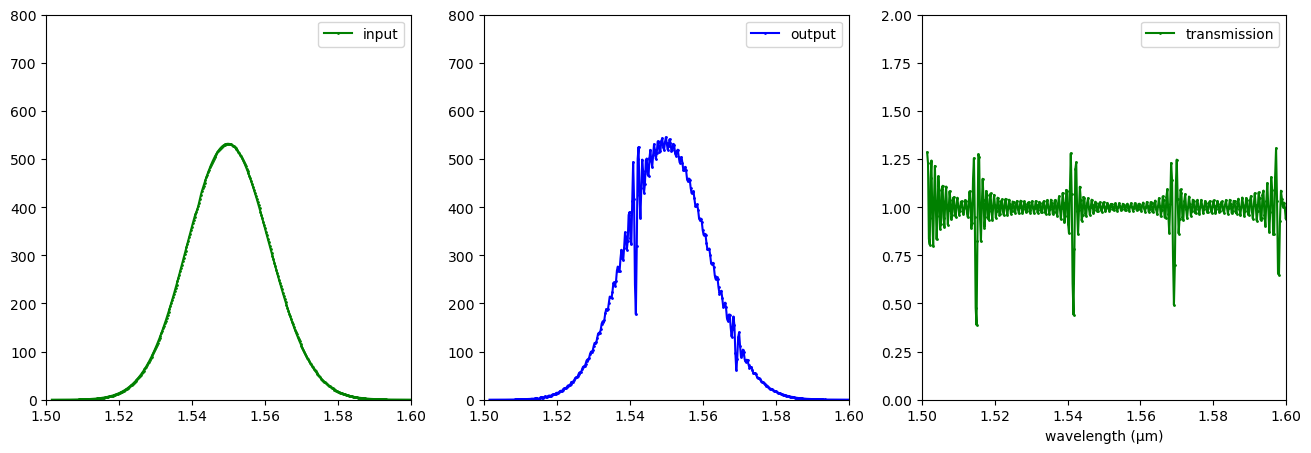

In [13]:
from matplotlib import markers


wl = []
Rs = []
Ts = []
Is = []
Os = []
print(flux_freqs)
print(ring_tran_flux)
print(ring_inp_flux)
for i in range(nfreq):
    wl = np.append(wl, 1 / flux_freqs[i])
    Os = np.append(Os, ring_tran_flux[i])
    Is = np.append(Is, ring_inp_flux[i])
    # Ts = np.append(Ts, ring_tran_flux[i] / ring_inp_flux[i])
    Ts = np.append(Ts, ring_tran_flux[i] / ring_inp_flux[i])

if mp.am_master():
    # plt.figure(dpi=150, figsize=(9,3))
    xlim = [1.5, 1.6]
    fig, axes = plt.subplots(1, 3, figsize=(16,5))
    # plt.plot(wl, Ts, "ro-", label="transmittance")
    axes[0].plot(wl, Is, "go-", label="input", markersize=1)
    axes[0].set(xlim=xlim, ylim=[0, 800])
    axes[0].legend(loc="upper right")

    axes[1].plot(wl, Os, "bo-", label="output", markersize=1)
    axes[1].set(xlim=xlim, ylim=[0, 800])
    axes[1].legend(loc="upper right")

    axes[2].plot(wl, Ts, "go-", label="transmission", markersize=1)
    axes[2].set(xlim=xlim, ylim=[0, 2])
    axes[2].legend(loc="upper right")
    # plt.axis([1.4, 1.6, 0, 150])
    plt.xlabel("wavelength (μm)")
    # plt.legend(loc="upper right")
    plt.show()